# Gradient Threshold
We used canny edge detection to find pixels that were likely to be part of a line in an image. Canny gave us a lot of edges on scenery, and cars, and other objects that we ended up discarding.
![](./img/Canny-Edge-Detection.png)

We know that the lines we are looking for are close to vertical. How we can take advantage of that fact?
We can use the gradient in smarter way. In Canny we were taking a derivative with respect to x and y in the process of finding the edges.

## Sobel Operator
The Sobel operator is at the heart of the Canny edge detection algorithm you used in the Introductory Lesson. Applying the Sobel operator to an image is a way of taking the derivative of the image in the x or y direction. The operators for **Sobel_x** and **Sobel_y** respectively, look like this:
![](./img/Sobel-Operator.png)

A larger kernel (5x5,...) implies taking the gradient over a larger region of the image, or, in other words, a smoother gradient.   

To understand how these operators take the derivative, you can think of overlaying either one on a 3 x 3 region of an image. If the image is flat across that region, then the result (summing the element-wise product of the operator and corresponding image pixels) will be zero. If, instead, for example, you apply the S_x operator to a region of the image where values are rising from left to right, then the result will be positive, implying a positive derivative. 

![](./img/Sobel-Operator-Example.png)

The Absolute value of Sobel_x and Sobel_y:
![](./img/Sobelx-vs-Sobely.png)

In the above images, you can see that the gradients taken in both the x and the y directions detect the lane lines and pick up other edges. Taking the gradient in the x direction emphasizes edges closer to vertical. Alternatively, taking the gradient in the y direction emphasizes edges closer to horizontal.   
In the upcoming exercises, you'll write functions to take various thresholds of the x and y gradients. Here's some code that might be useful:   

You need to pass a single color channel to the `cv2.Sobel()` function, so first convert it to grayscale
```python
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
```
**Note**: Make sure you use the correct grayscale conversion depending on how you've read in your images. Use `cv2.COLOR_RGB2GRAY` if you've read in an image using `mpimg.imread()`. Use `cv2.COLOR_BGR2GRAY` if you've read in an image using `cv2.imread()`.

Calculate the derivative in the x direction (the 1, 0 at the end denotes x direction):
```python
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
```
Calculate the derivative in the y direction (the 0, 1 at the end denotes y direction):
```python
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
```
Calculate the absolute value of the x derivative:
```python
abs_sobelx = np.absolute(sobelx)
```
Convert the absolute value image to 8-bit:
```python
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
```
**Note**: It's not entirely necessary to convert to 8-bit (range from 0 to 255) but in practice, it can be useful in the event that you've written a function to apply a particular threshold, and you want it to work the same on input images of different scales, like jpg vs. png.  

Create a binary threshold to select pixels based on gradient strength:
```python
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')
```

**Result**
![](./img/X-gradient.png)

### Example:
Your goal in this exercise is to identify pixels where the gradient of an image falls within a specified threshold range.

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [13]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

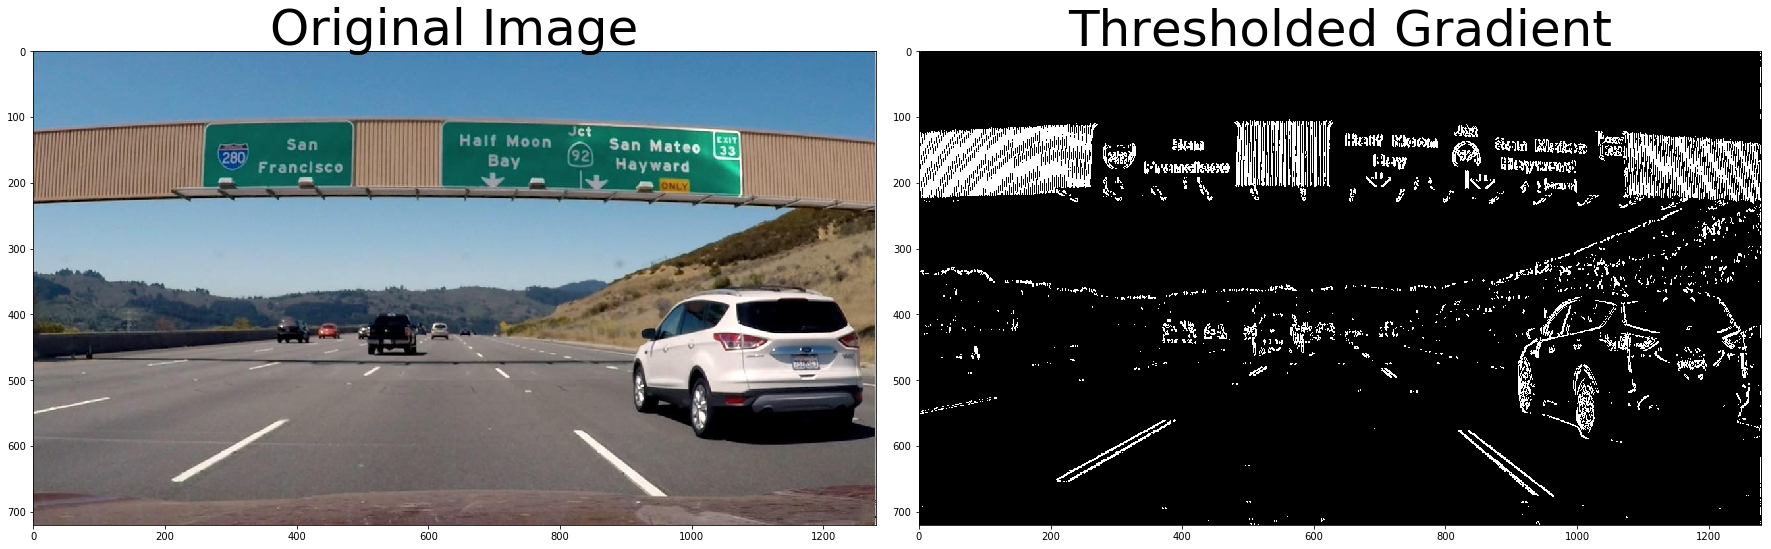

In [14]:
# Read in an image and grayscale it
image = mpimg.imread('./img/signs_vehicles_xygrad.png')
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Magnitude of the Gradient
Now the goal is to apply a threshold to the overall magnitude of the gradient, in both x and y.

The magnitude, or absolute value, of the gradient is just the square root of the squares of the individual x and y gradients. For a gradient in both the x and y directions, the magnitude is the square root of the sum of the squares.

![](./img/Absolute_Sobel.png)

It's also worth considering the size of the region in the image over which you'll be taking the gradient. You can modify the kernel size for the Sobel operator to change the size of this region. Taking the gradient over larger regions can smooth over noisy intensity fluctuations on small scales. The default Sobel kernel size is 3, but here you'll define a new function that takes kernel size as a parameter (must be an odd number!)

## A simple edge detector using gradient magnitude
* Compute gradient vector at each pixel by convolving image with horizontal and vertical derivative filters
* Compute gradient magnitude at each pixel
* If magnitude at a pixel exceeds a threshold, report a possible edge point

### Example:
1. Fill out the function in the editor below to return a thresholded gradient magnitude
2. Test that your function returns output similar to the example below for `sobel_kernel=9`,  `mag_thresh=(30, 100)`.

In [24]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt (sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

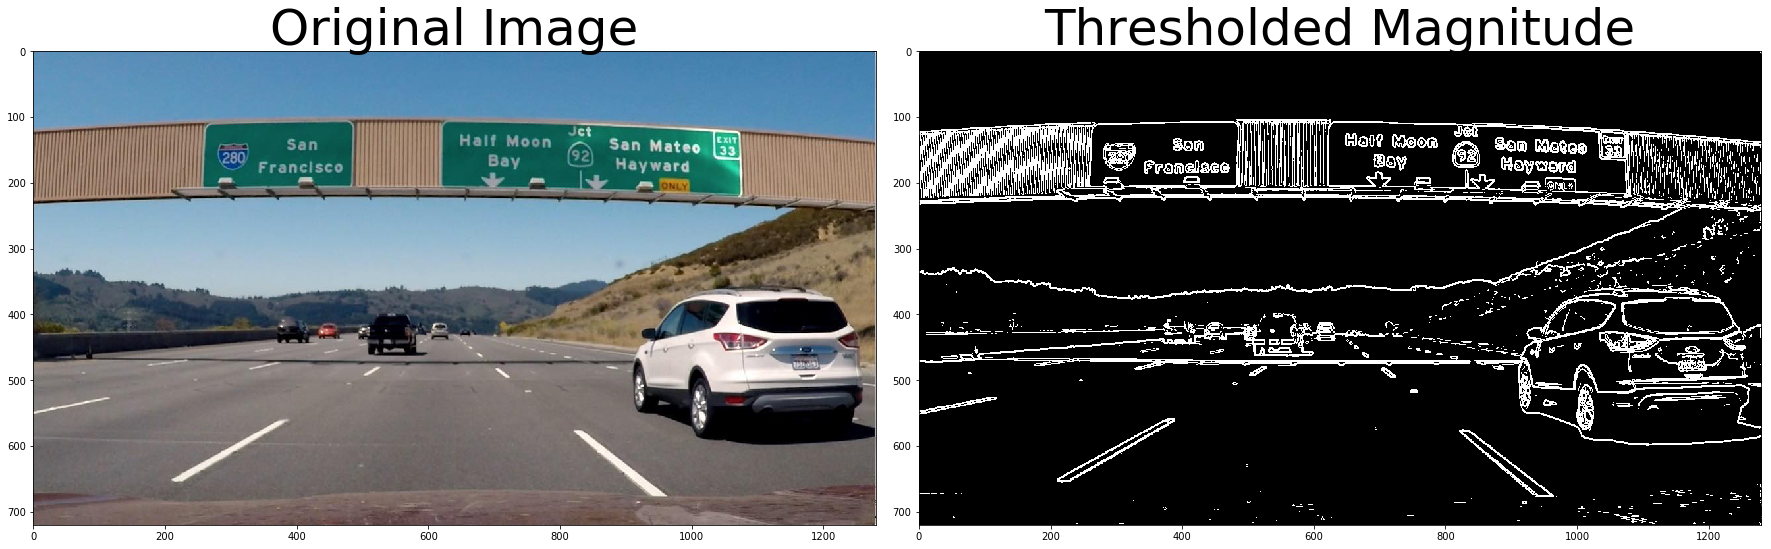

In [50]:
# Read in an image
image = mpimg.imread('./img/signs_vehicles_xygrad.png')
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 200))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Direction of the Gradient

When you play around with the thresholding for the gradient magnitude in the previous exercise, you find what you might expect, namely, that it picks up the lane lines well, but with a lot of other stuff detected too.  
Gradient magnitude is at the heart of Canny edge detection, and is why Canny works well for picking up all edges.  

In the case of lane lines, we're interested only in edges of a particular orientation. So now we will explore the direction, or orientation, of the gradient.   

The direction of the gradient is simply the inverse tangent (arctangent) of the y gradient divided by the x gradient:  
**arctan(sobel_y/sobel_x)**  

Each pixel of the resulting image contains a value for the angle of the gradient away from horizontal in units of radians, covering a range of −π/2 to π/2. An orientation of 0 implies a horizontal line and orientations of +/−π/2 imply vertical lines. 

### Example:

In [49]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):   
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir=np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    binary_output[(absgraddir >= thresh_min) & (absgraddir <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

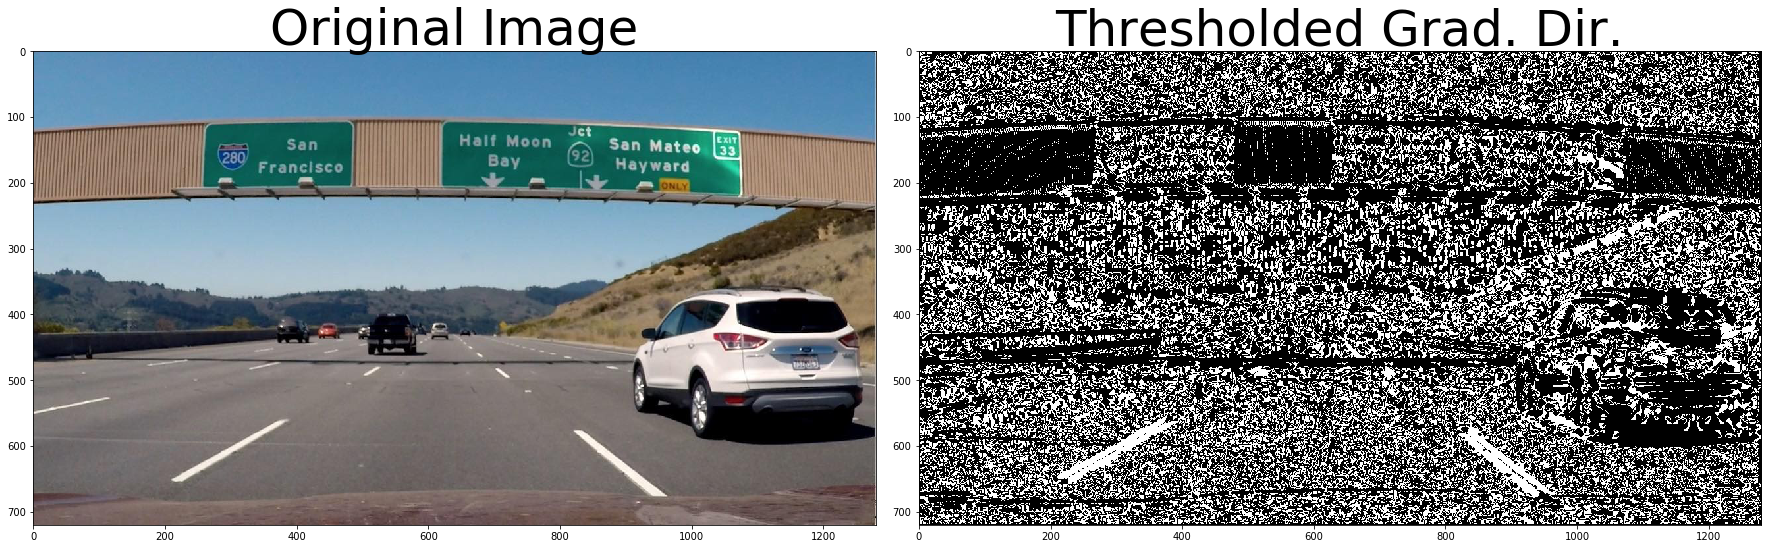

In [51]:
# Read in an image
image = mpimg.imread('./img/signs_vehicles_xygrad.png')
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combining Thresholds
If you play around with the thresholds in the last exercise, you'll find that you can start to identify the lane lines by gradient direction alone by setting the threshold around thresh = (0.7, 1.3), but there's still a lot of noise in the resulting image.    

Now consider how you can use various aspects of your gradient measurements (x, y, magnitude, direction) to isolate lane-line pixels. Specifically, think about how you can use thresholds of the x and y gradients, the overall gradient magnitude, and the gradient direction to focus on pixels that are likely to be part of the lane lines. 

In [56]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply threshold
    binary_output = np.zeros_like(scaled_sobel)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
   
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
   
    # Calculate gradient magnitude
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt (sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
   
    # Apply threshold
    binary_output = np.zeros_like(scaled_sobel)
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
   
    # Calculate directional gradient
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir=np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply threshold
    binary_output = np.zeros_like(absgraddir)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    binary_output[(absgraddir >= thresh_min) & (absgraddir <= thresh_max)] = 1
    return dir_binary

In [57]:
image = mpimg.imread('./img/signs_vehicles_xygrad.png')
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

Try different combinations and see what you get.

For example, here is a selection for pixels where both the x and y gradients meet the threshold criteria, or the gradient magnitude and direction are both within their threshold values

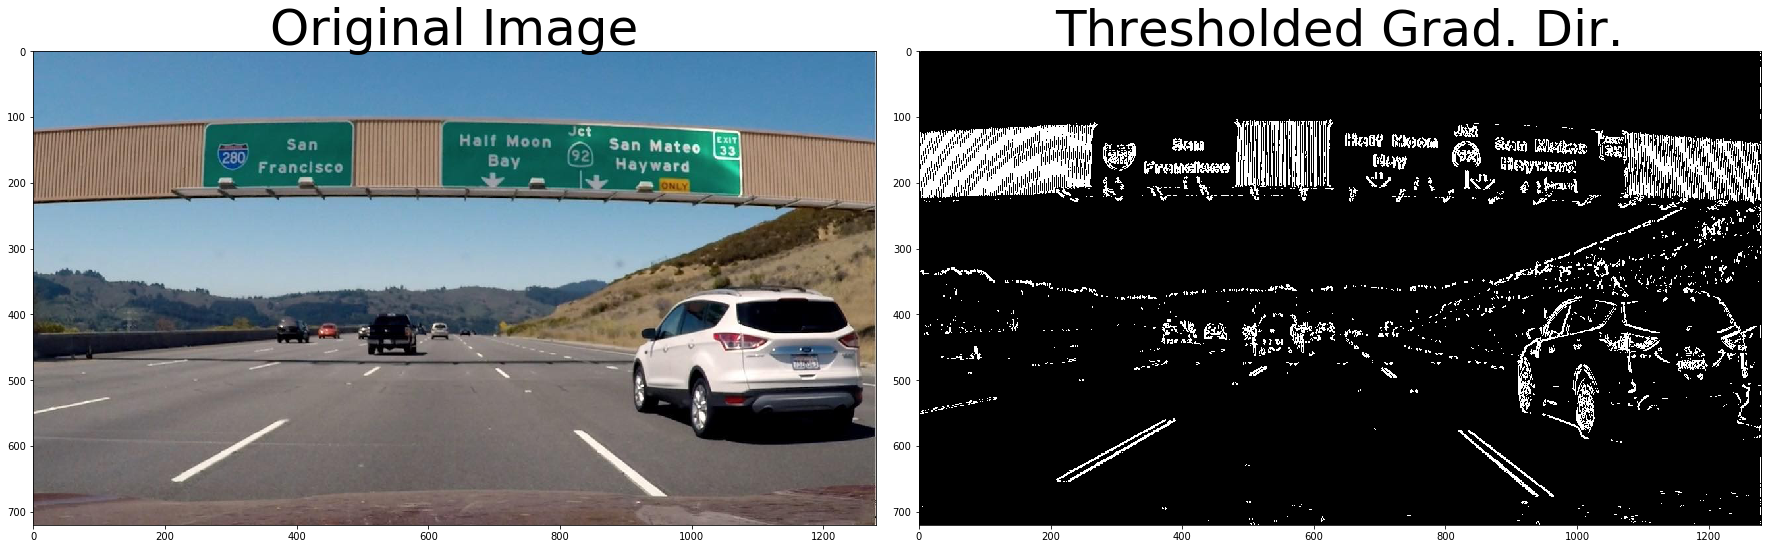

In [59]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)